In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import sys
import random
sys.path.append('../src/')
from random_graph import RandGraph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
g = RandGraph()

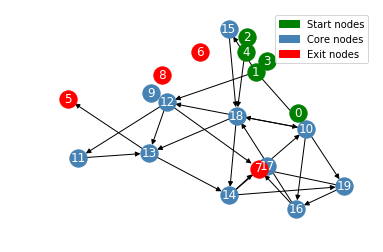

In [4]:
g.plot()

In [24]:
data, nodes = g.step(n=10)

% 90  |||||||||

In [26]:
data.mean(axis=1)

array([0.        , 0.03636364, 0.1038961 , 0.04935065, 0.01298701,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

### Parameters

* actors=5, 
* moving=2, 
* n_entry_nodes=5, 
* n_exit_nodes=4, 
* n_core_nodes=11, 
* n_paths=5, 
* path_depth=6

In [7]:
from itertools import product

In [5]:
settings = {}

In [6]:
moving = list(range(2,50,2))
n_entry_nodes = list(range(2,10))
n_exit_nodes = list(range(2,10))
n_core_nodes = list(range(10,50,5))
n_paths = list(range(5,50,5))

In [8]:
i = 0
for ma,en,ex,cn,p in product(moving,n_entry_nodes,n_exit_nodes, n_core_nodes, n_paths):
    settings[i] = {'moving':ma,
                  'entry_nodes': en,
                  'exit_nodes': ex,
                  'core_nodes': cn,
                  'n_paths': p}
    i += 1

In [10]:
len(settings)

110592

In [11]:
def gen_settings():
    for k,v in settings.items():
        yield k,v

In [35]:
count = 0
results = pd.DataFrame()
for i,v in gen_settings():
    g = RandGraph(actors=10000, 
                  moving=v['moving'], 
                  n_entry_nodes=v['entry_nodes'],
                 n_exit_nodes=v['exit_nodes'],
                 n_core_nodes=v['core_nodes'],
                 n_paths=v['n_paths'])
    data, nodes = g.step(n=100)
    results[i] = data.mean(axis=1)
    
    count += 1
    if count == 100:
        break

% 99 ||||||||||

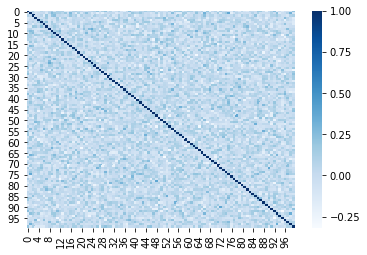

In [37]:
sns.heatmap(results.corr(), cmap='Blues')
plt.show()

In [82]:
min_idx = results.mean(axis=0).idxmin()

In [83]:
max_idx = results.mean(axis=0).idxmax()

In [84]:
settings[min_idx]

{'moving': 2,
 'entry_nodes': 2,
 'exit_nodes': 2,
 'core_nodes': 45,
 'n_paths': 25}

In [85]:
settings[max_idx]

{'moving': 2,
 'entry_nodes': 2,
 'exit_nodes': 2,
 'core_nodes': 15,
 'n_paths': 5}

In [89]:
g = RandGraph(actors=10000, 
                  moving=2, 
                  n_entry_nodes=2,
                 n_exit_nodes=2,
                 n_core_nodes=45,
                 n_paths=25)
data, nodes = g.step(n=100)
df_min = pd.DataFrame(data, columns=nodes)

% 99 ||||||||||

In [90]:
g = RandGraph(actors=10000, 
                  moving=2, 
                  n_entry_nodes=2,
                 n_exit_nodes=2,
                 n_core_nodes=15,
                 n_paths=5)
data, nodes = g.step(n=100)
df_max = pd.DataFrame(data, columns=nodes)

% 99 ||||||||||

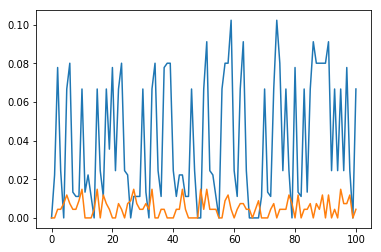

In [91]:
df_max.mean(axis=1).plot(kind='line')
df_min.mean(axis=1).plot(kind='line')
plt.show()

## Random search

In [92]:
from random import choice

In [111]:
rand_sets= {}
data_mean = np.zeros((101,10))
data_std = np.zeros((101, 10))
for i in range(10):
    moving = choice(list(range(2,50,2)))
    n_entry_nodes = choice(list(range(2,10)))
    n_exit_nodes = choice(list(range(2,10)))
    n_core_nodes = choice(list(range(10,50,5)))
    n_paths = choice(list(range(5,50,5)))
    rand_sets[i] = {'moving':moving,
                   'n_entry_nodes':n_entry_nodes,
                   'n_exit_nodes':n_exit_nodes,
                   'n_core_nodes':n_core_nodes,
                   'n_paths':n_paths}
    # cross validation
    cv = np.zeros((101,5))
    for j in range(5):
        g = RandGraph(actors=10000, 
                          moving = moving, 
                          n_entry_nodes = n_entry_nodes,
                         n_exit_nodes = n_exit_nodes,
                         n_core_nodes = n_core_nodes,
                         n_paths = n_paths)
        data, nodes = g.step(n=100)
        cv[:,j] = data.mean(axis=1)
    data_mean[:,i] = cv.mean(axis=1)
    data_std[:,i] = cv.std(axis=1)

% 99 ||||||||||

In [112]:
data_mean_plus_std = data_mean + data_std
data_mean_minus_std = data_mean - data_std

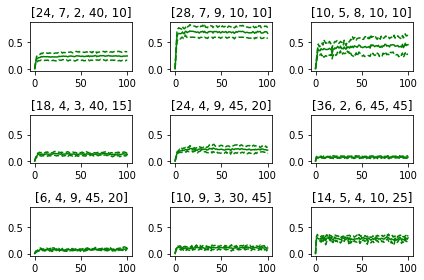

In [118]:
fig = plt.figure()
for i in range(9):
    ax = fig.add_subplot(3,3,i+1, sharex=ax, sharey=ax)
    ax.plot(data_mean_minus_std[:,i], 'g--')
    ax.plot(data_mean[:,i],'g')
    ax.plot(data_mean_plus_std[:,i], 'g--')
    ax.set_title(list(rand_sets[i].values()))
plt.tight_layout()
plt.show()

## Observations:
* mean values evaluated by cross validation seem a good proxy
* the number of steps do not matter, we can use the mean after 20 - 30 steps
* we may produce a regression model to find which coeficient is the most important for graph congestion 
* what happens if a seasonal number of actors enter in the graph ? do we observe graph saturation ? Do we observe a delay in graph saturation ?